In [14]:
#! pip install ultralytics 
#! pip install psycopg2
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from ultralytics import YOLO
import psycopg2
import im_utils
import db_ops

#### Get the full list of OLM images

In [7]:
query = f'''
SELECT s3_uri AS uri
FROM image;
'''
image_uri = db_ops.select_to_pandas(query, True, True)

/home/ubuntu/workspace/litter-imagery-brand-recognition/db_ops.py:57: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


In [8]:
image_uri.head()

,uri
0,s3://olm-pics-s3/112/Pftq4550WzgZA5euhgIEsLHGs...
1,s3://olm-pics-s3/112/HKXafwXvrpBQjoWC9aPtSY8lT...
2,s3://olm-pics-s3/112/69M58FGWNVp1ZTObF0YmkMfGN...
3,s3://olm-pics-s3/112/Da9HiIUxqaxY7WeKi2INrzgTG...
4,s3://olm-pics-s3/112/pUY1im8pNbPUAceAv17T5SCvm...


#### Load the label/no-label classifier model

In [9]:
model = YOLO('/home/ubuntu/box_model/best.pt')

#### Copy the image from the original S3, resize it, save to the procesed S3

In [29]:
original_im_uri = image_uri['uri'].iloc[0]
tmp_im_folder = '/home/ubuntu/temp-images'
im_file = original_im_uri.split('/')[-1]
scaled_im_uri = original_im_uri.replace('-pics-s3', '-processed-s3/scaled')
scaled_im_path = os.path.join(tmp_im_folder, 'scaled')

In [38]:
os.system(f"aws s3 cp {original_im_uri} {tmp_im_folder}")  
image_original = cv2.imread(tmp_im_folder+'/'+im_file)
image_scaled = im_utils.ScaleImage(image_original, width = 640)
cv2.imwrite(scaled_im_path + '/' + im_file, image_scaled)
os.system(f"aws s3 cp {scaled_im_path + '/' + im_file} {scaled_im_uri}") 

download: s3://olm-pics-s3/112/Pftq4550WzgZA5euhgIEsLHGs63tXSHAqCP07WKl.jpeg to ../../temp-images/Pftq4550WzgZA5euhgIEsLHGs63tXSHAqCP07WKl.jpeg
upload: ../../temp-images/scaled/Pftq4550WzgZA5euhgIEsLHGs63tXSHAqCP07WKl.jpeg to s3://olm-processed-s3/scaled/112/Pftq4550WzgZA5euhgIEsLHGs63tXSHAqCP07WKl.jpeg


0

#### Find bounding boxes for potential labels

In [39]:
# Run the model inference on the test images
results = model(scaled_im_path + '/' + im_file, conf = 0.2)


image 1/1 /home/ubuntu/temp-images/scaled/Pftq4550WzgZA5euhgIEsLHGs63tXSHAqCP07WKl.jpeg: 480x640 1 logo, 34.5ms
Speed: 1.2ms preprocess, 34.5ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


Pftq4550WzgZA5euhgIEsLHGs63tXSHAqCP07WKl-792-1112-932-1416.jpg


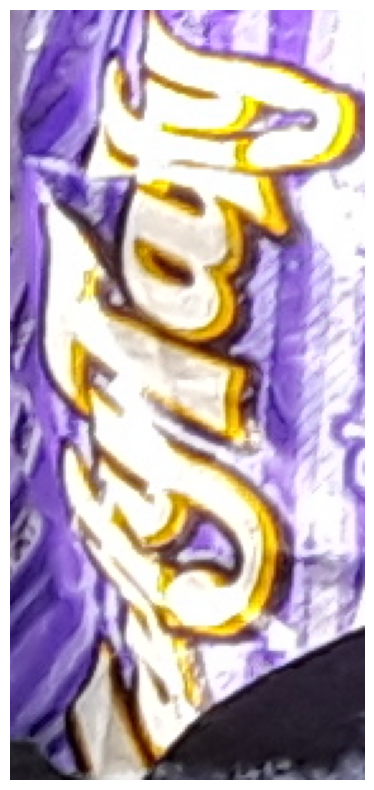

In [64]:
for result in results: # Iterate over each picture 
    # Find the saceling factor
    w_ratio = image_original.shape[1]/image_scaled.shape[1]
    h_ratio = image_original.shape[0]/image_scaled.shape[0]
    for prediction in result.boxes.xyxy:   # Iterate over each box
        # Get the coordinates of the box on the original image
        xmin, ymin, xmax, ymax = map(int, prediction) 
        xmin = int(xmin * w_ratio)
        xmax = int(xmax * w_ratio)
        ymin = int(ymin * h_ratio)
        ymax = int(ymax * h_ratio)
        postfix = f"-{xmin}-{ymin}-{xmax}-{ymax}"
        box_file = im_file.split('.')[0]+postfix+'.jpg' 
        print(box_file)
        # Get the section of the original image that is in the box
        box_im = image_original[ymin:ymax, xmin:xmax,:]
        # Save the box as an individual file
        cv2.imwrite(scaled_im_path + '/' + box_file, box_im)

        
    # Create a plot
    plt.figure(figsize=(10, 10))
    plt.imshow(box_im)
    plt.axis('off') # Hide the axis
    plt.show()